In [2]:
%config Completer.use_jedi = False

In [56]:
import warnings
import itertools

import pandas as pd
import numpy as np

from pandas.plotting import autocorrelation_plot

import matplotlib.pyplot as plt
from pylab import rcParams

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import statsmodels

from statsmodels.tsa.arima.model import ARIMA

import pmdarima as pm

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

### Data

In [4]:
perthTemp = pd.read_csv("data/PerthTemperatures.csv")

### Check NULLs

In [5]:
perthTemp.isnull().sum()

Year                               1
Month                              1
Day                                1
Minimum temperature (Degree C)    76
Maximum temperature (Degree C)    31
Rainfall amount (millimetres)      0
Quality                           31
dtype: int64

In [6]:
perthTemp.drop(columns=['Quality'], inplace=True)

### Handle NULLs

In [7]:
perthTemp.fillna(method='bfill', inplace = True)

In [8]:
perthTemp.isnull().sum()

Year                              1
Month                             1
Day                               1
Minimum temperature (Degree C)    0
Maximum temperature (Degree C)    1
Rainfall amount (millimetres)     0
dtype: int64

In [9]:
perthTemp.drop(perthTemp.tail(1).index, inplace=True)

In [10]:
perthTemp.isnull().sum()

Year                              0
Month                             0
Day                               0
Minimum temperature (Degree C)    0
Maximum temperature (Degree C)    0
Rainfall amount (millimetres)     0
dtype: int64

### Handle dates

In [11]:
perthTemp

,Year,Month,Day,Minimum temperature (Degree C),Maximum temperature (Degree C),Rainfall amount (millimetres)
0,1944.0,6.0,3.0,11.0,22.3,0.0
1,1944.0,6.0,4.0,12.2,23.4,0.0
2,1944.0,6.0,5.0,12.0,20.3,2.0
3,1944.0,6.0,6.0,7.4,18.7,3.3
4,1944.0,6.0,7.0,5.9,21.3,0.3
...,...,...,...,...,...,...
27641,2020.0,2.0,6.0,21.0,32.6,0.0
27642,2020.0,2.0,7.0,20.7,30.6,0.0
27643,2020.0,2.0,8.0,19.6,28.2,0.0
27644,2020.0,2.0,9.0,14.1,29.8,0.0


In [12]:
perthTemp['Date'] = pd.to_datetime(perthTemp[['Year', 'Month', 'Day']])

In [13]:
perthTemp.drop(columns=['Year', 'Month', 'Day'], inplace = True)

In [14]:
perthTemp.dtypes

Minimum temperature (Degree C)           float64
Maximum temperature (Degree C)           float64
Rainfall amount (millimetres)            float64
Date                              datetime64[ns]
dtype: object

### Set date as index

In [15]:
# Set the date as index 
perthTemp_2 = perthTemp.set_index('Date')

In [16]:
perthTemp_2

,Minimum temperature (Degree C),Maximum temperature (Degree C),Rainfall amount (millimetres)
Date,,,
1944-06-03,11.0,22.3,0.0
1944-06-04,12.2,23.4,0.0
1944-06-05,12.0,20.3,2.0
1944-06-06,7.4,18.7,3.3
1944-06-07,5.9,21.3,0.3
...,...,...,...
2020-02-06,21.0,32.6,0.0
2020-02-07,20.7,30.6,0.0
2020-02-08,19.6,28.2,0.0


### Split

In [17]:
perthTemp_Train = perthTemp_2[:'2010-12-31']

perthTemp_Test = perthTemp_2['2011-01-01':]

### Resample

In [18]:
perthTemp_Train_MS = perthTemp_Train.resample('MS').mean()
perthTemp_Test_MS = perthTemp_Test.resample('MS').mean()

In [20]:
perthTemp_Train_MS.rename(columns={'Minimum temperature (Degree C)':'mintemp',
                                   'Maximum temperature (Degree C)':'maxtemp',
                                   'Rainfall amount (millimetres)':'rainfall'}, inplace = True)

perthTemp_Test_MS.rename(columns={'Minimum temperature (Degree C)':'mintemp',
                                   'Maximum temperature (Degree C)':'maxtemp',
                                   'Rainfall amount (millimetres)':'rainfall'}, inplace = True)

### Visualizing the time series

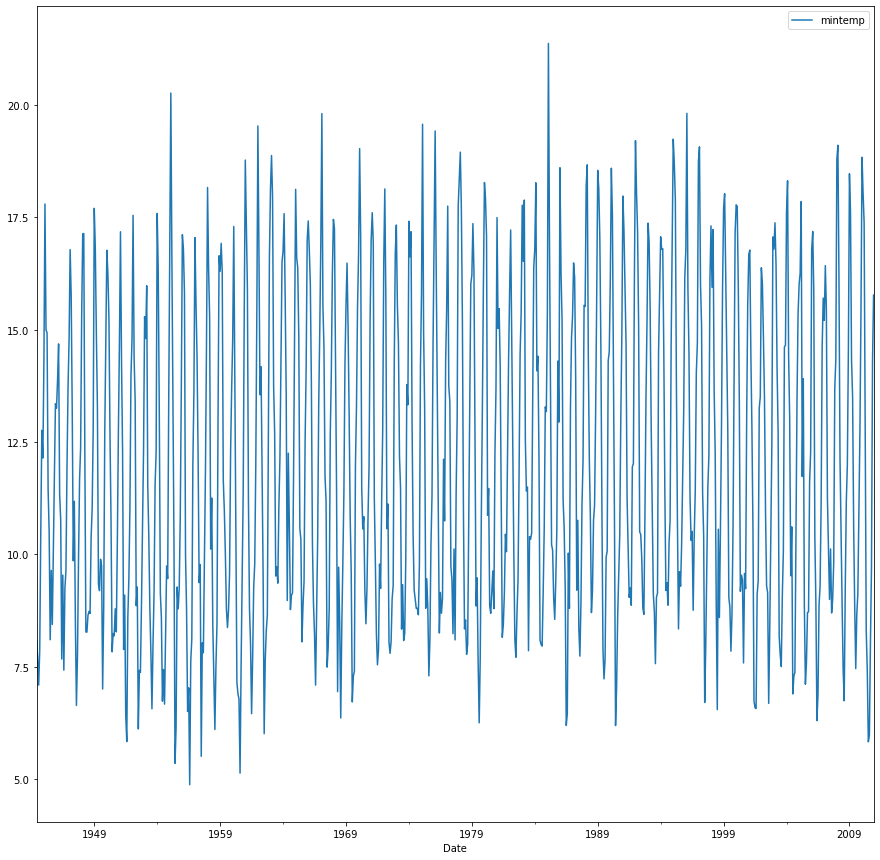

In [21]:
perthTemp_Train_MS[['mintemp']].plot(figsize=(15, 15))
plt.show()

### Decomposing the Time Series

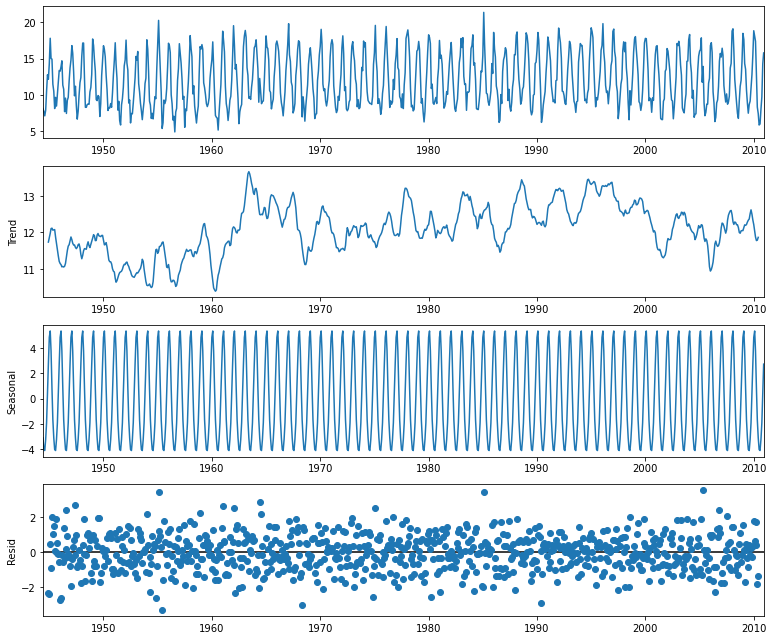

In [24]:
rcParams['figure.figsize'] = 11, 9

decomposition = sm.tsa.seasonal_decompose(perthTemp_Train_MS[['mintemp']], model='additive')
fig = decomposition.plot()
plt.show()

### Stationarity Tests

#### Augmented Dickey Fuller Test - ADF

In [25]:
def adf_test(ts, signif=0.05):
    dftest = adfuller(ts, autolag='AIC')
    adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
    
    for key,value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    print (adf)
    
    p = adf['p-value']
    if p <= signif:
        print(f" Series is Stationary")
    else:
        print(f" Series is Non-Stationary")

In [26]:
#apply adf test on the series
adf_test(perthTemp_Train_MS[['mintemp']])

Test Statistic           -3.975318
p-value                   0.001545
# Lags                   21.000000
# Observations          777.000000
Critical Value (1%)      -3.438794
Critical Value (5%)      -2.865267
Critical Value (10%)     -2.568755
dtype: float64
 Series is Stationary


### Differencing a time series

### Finding p (AR Term) q (MA Term) and d (Differencing)

### Auto correlation plots

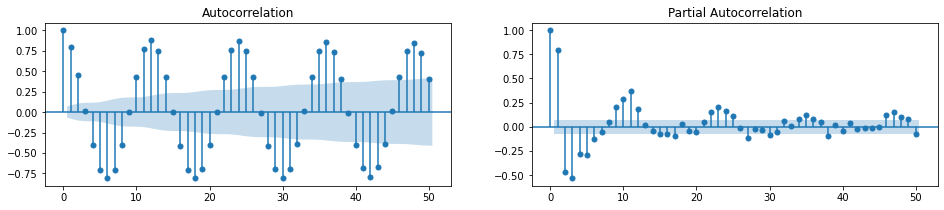

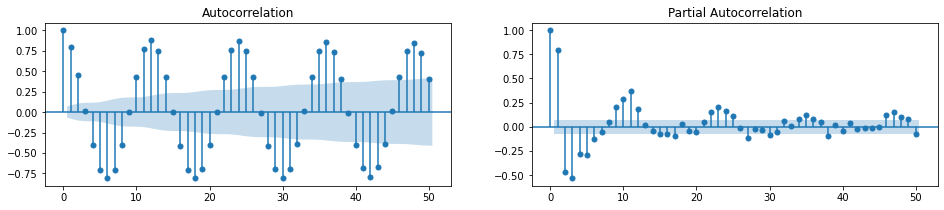

In [27]:
fig, axes = plt.subplots(1,2,figsize=(16,3))
plot_acf(perthTemp_Train_MS.mintemp.tolist(), lags=50, ax=axes[0])
plot_pacf(perthTemp_Train_MS.mintemp.tolist(), lags=50, ax=axes[1])

### ARIMA

In [40]:
# 1,1,2 ARIMA Model
model = None
model = ARIMA(perthTemp_Train_MS[['mintemp']], order=(1,0,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                mintemp   No. Observations:                  799
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1715.718
Date:                Sun, 25 Apr 2021   AIC                           3439.437
Time:                        19:25:24   BIC                           3458.170
Sample:                    06-01-1944   HQIC                          3446.634
                         - 12-01-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0708      0.334     36.162      0.000      11.417      12.725
ar.L1          0.7147      0.034     20.811      0.000       0.647       0.782
ma.L1          0.2713      0.046      5.934      0.0

### Model Diagnostics (Residuals)

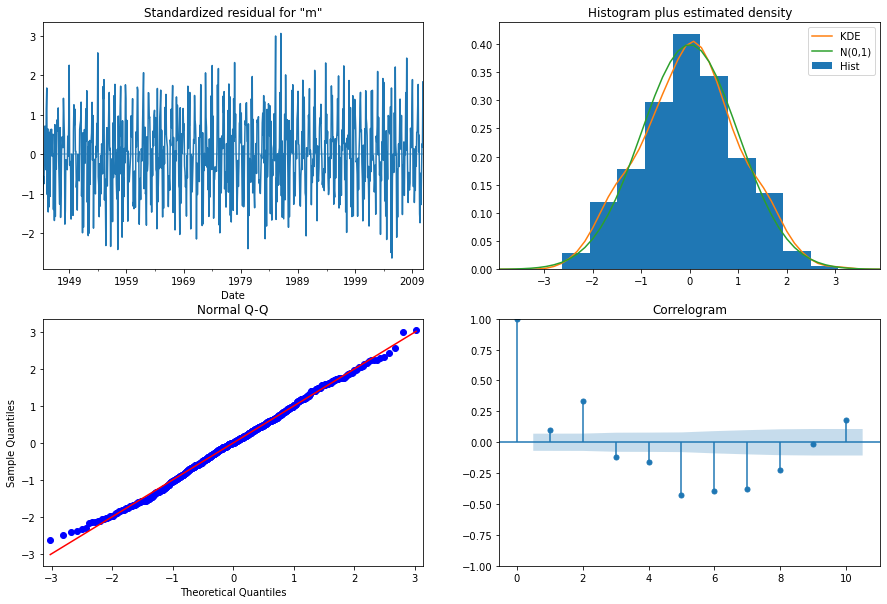

In [41]:
# model_fit.plot_predict(dynamic=False)

model_fit.plot_diagnostics(figsize=(15,10))
plt.show()

### Play with forecasting

In [42]:
model = None
model = ARIMA(perthTemp_Train_MS[['mintemp']], order=(1, 0, 1))  
fitted = model.fit()

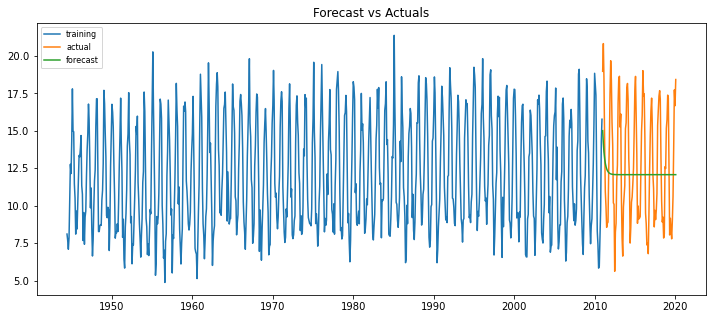

In [43]:
# Forecast
fc = fitted.forecast(len(perthTemp_Test_MS), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=perthTemp_Test_MS[['mintemp']].index)

# Plot
plt.figure(figsize=(12,5))
plt.plot(perthTemp_Train_MS[['mintemp']], label='training')
plt.plot(perthTemp_Test_MS[['mintemp']], label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

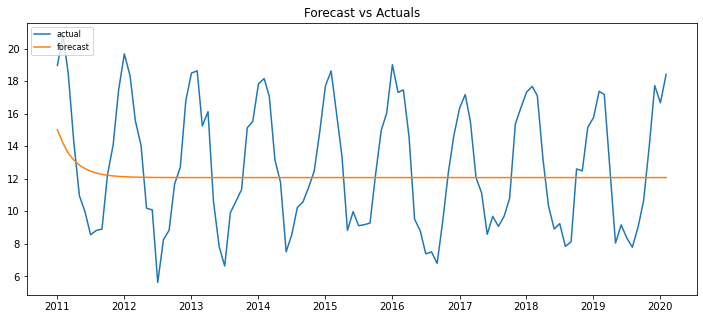

In [44]:
# Forecast
fc = fitted.forecast(len(perthTemp_Test_MS), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=perthTemp_Test_MS[['mintemp']].index)

# Plot
plt.figure(figsize=(12,5))
# plt.plot(perthTemp_Train_MS[['mintemp']], label='training')
plt.plot(perthTemp_Test_MS[['mintemp']], label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### Metrics

In [57]:
mae = mean_absolute_error(fc, perthTemp_Test_MS[['mintemp']].values)
print('MAE: %.3f' % mae)

mape = mean_absolute_percentage_error(fc, perthTemp_Test_MS[['mintemp']].values)
print('MAPE: %.3f' % mape)

MAE: 3.321
MAPE: 0.273


### Auto ARIMA

In [59]:
model = None
model = pm.auto_arima(perthTemp_Train_MS[['mintemp']], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3547.373, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6317.045, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3600.612, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5407.312, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3504.104, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=3515.287, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=3462.229, Time=0.17 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=3478.833, Time=0.11 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=2955.943, Time=0.58 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3447.155, Time=0.16 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=3449.426, Time=0.45 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=3460.978, Time=0.40 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=2969.794, Time=0.87 sec

Best model:  ARIMA(3,0,2)(0,0,0)[0]          
Total fit time: 3.185 seconds
                      

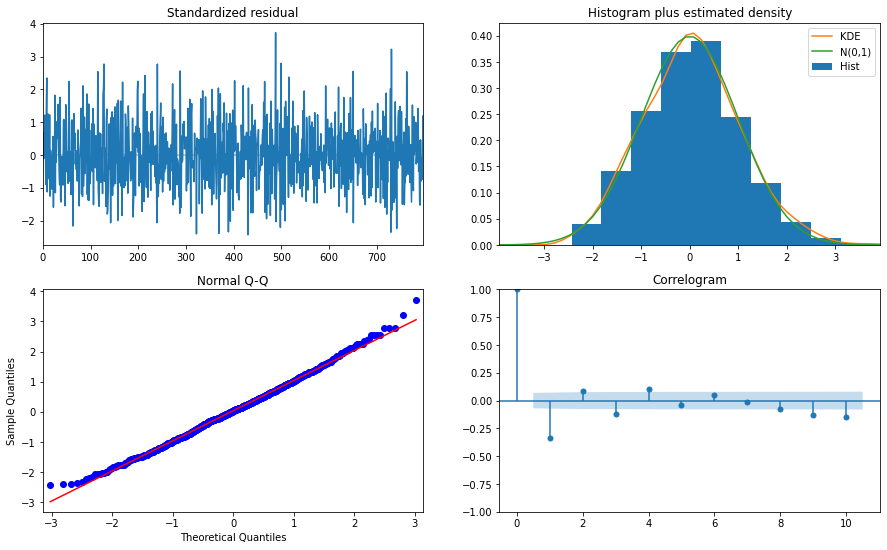

In [60]:
model.plot_diagnostics(figsize=(15,9))
plt.show()

In [62]:
fitted = None

fitted = model.fit(perthTemp_Train_MS[['mintemp']])

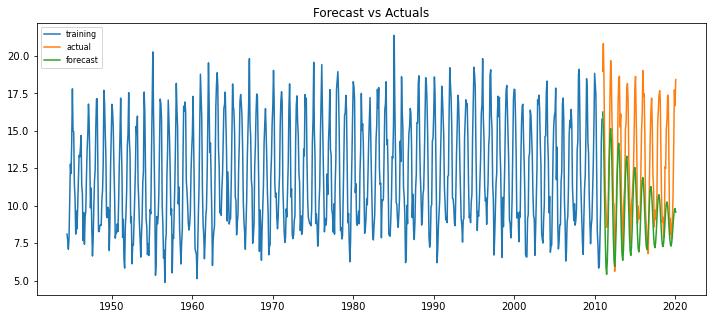

In [64]:
# Forecast
fc = fitted.predict(len(perthTemp_Test_MS))  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=perthTemp_Test_MS.index)

# Plot
plt.figure(figsize=(12,5))
plt.plot(perthTemp_Train_MS[['mintemp']], label='training')
plt.plot(perthTemp_Test_MS[['mintemp']], label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

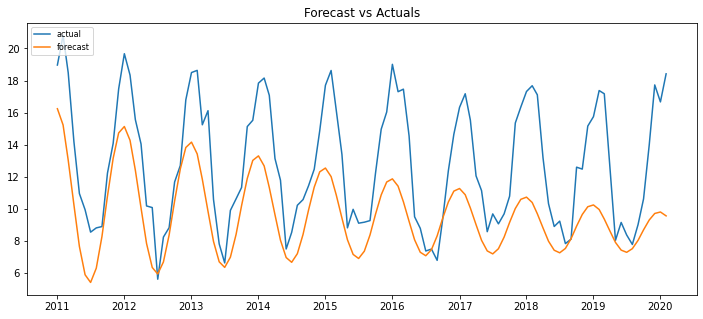

In [65]:
# Forecast
fc = fitted.predict(len(perthTemp_Test_MS))  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=perthTemp_Test_MS.index)

# Plot
plt.figure(figsize=(12,5))
# plt.plot(perthTemp_Train_MS[['mintemp']], label='training')
plt.plot(perthTemp_Test_MS[['mintemp']], label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### ARIMA cant do Seasonal Time Series

### SARIMA model

In [66]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(perthTemp_Train_MS[['mintemp']], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.90 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=3014.321, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2767.324, Time=0.35 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=3012.325, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2984.482, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2688.796, Time=0.75 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.83 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=2720.699, Time=0.72 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=2673.470, Time=0.85 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=2755.016, Time=0.42 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.15 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.27 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=2675.4

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  799
Model:             SARIMAX(2, 0, 3)x(2, 1, [], 12)   Log Likelihood               -1326.428
Date:                             Sun, 25 Apr 2021   AIC                           2668.856
Time:                                     19:47:55   BIC                           2706.202
Sample:                                          0   HQIC                          2683.214
                                             - 799                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1243      0.270      0.460      0.645      -0.405       0.654
ar.L2          0.5446      0.159      3.431      0.001       0.233       0.856
ma.L1          0.0568      0.272      0.209      0.835      -0.476       0.590
ma.L2         -0.3913      0.151     -2.597      0.009      -0.687      -0.096
ma.L3         -0.0935      0.062     -1.512      0.131      -0.215       0.028
ar.S.L12      -0.6575      0.033    -19.794      0.000      -0.723      -0.592
ar.S.L24      -0.3231      0.034     -9.379      0.000      -0.391      -0.256
sigma2         1.6908      0.086     19.635      0.000       1.522       1.860
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.65
Prob(Q):                              0.91   Prob(JB):                         0.72
Heteroskedasticity (H):               0.80   Skew:                             0.07
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

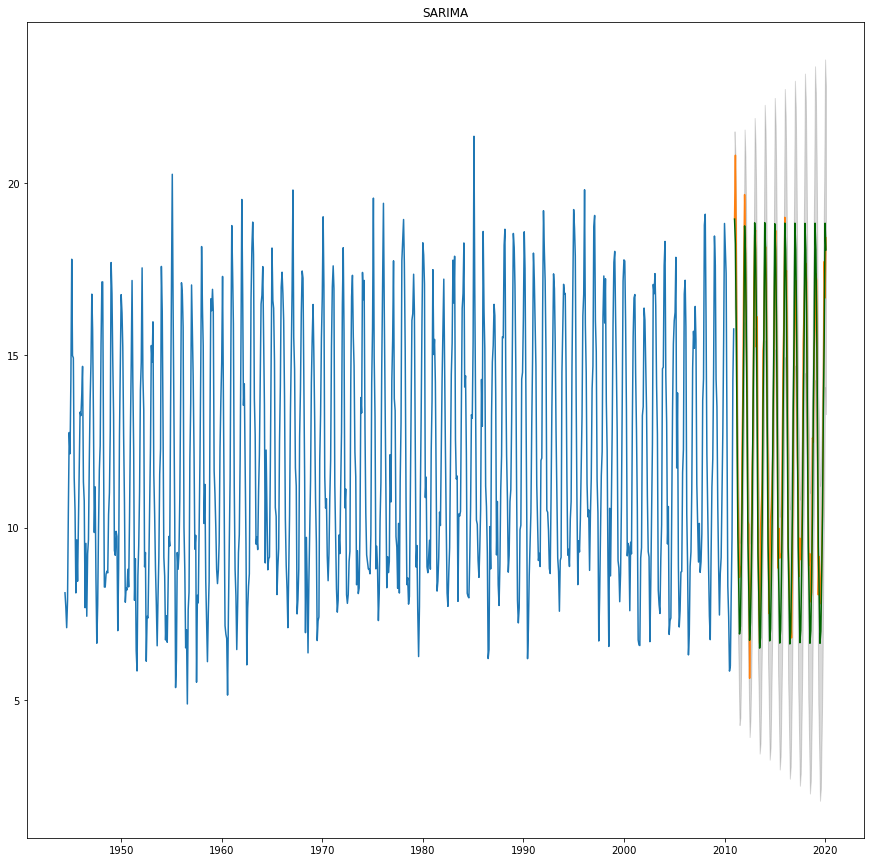

In [71]:
# Forecast
n_periods = len(perthTemp_Test_MS)
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = perthTemp_Test_MS.index

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(15,15))
plt.plot(perthTemp_Train_MS[['mintemp']])
plt.plot(perthTemp_Test_MS[['mintemp']])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA")
plt.show()

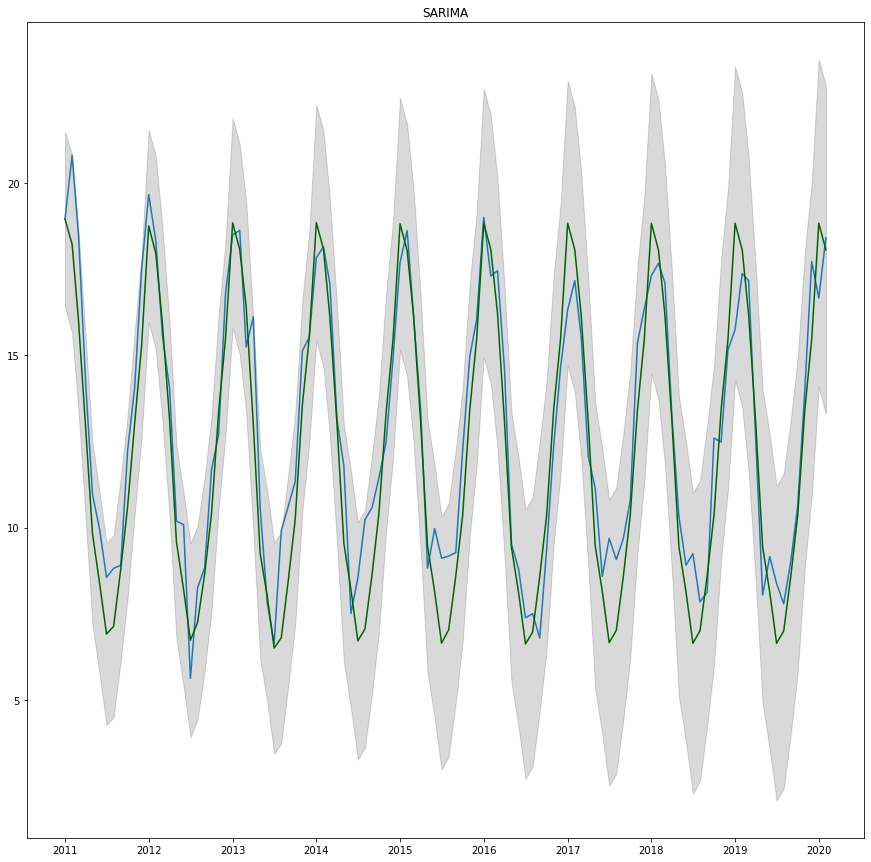

In [73]:
# Plot
plt.figure(figsize=(15,15))
# plt.plot(perthTemp_Train_MS[['mintemp']])
plt.plot(perthTemp_Test_MS[['mintemp']])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA")
plt.show()

In [74]:
mae = mean_absolute_error(perthTemp_Test_MS['mintemp'], fitted_series)
print('MAE: %.3f' % mae)

mape = mean_absolute_percentage_error(perthTemp_Test_MS['mintemp'], fitted_series)
print('MAPE: %.3f' % mape)

MAE: 1.148
MAPE: 0.099
